## In this chapter we will see how Gaussian Mixture Models (gmm) can help overcome some of the time series prediction issues we identified in chapter 1.

1. `GMM's can handle with nonstationarity e.g. time-dependent means and variances and autocorrelation`.

In [1]:
%load_ext watermark
%watermark

# import standard libs

import sys
import os
import time

# import python scientific stack

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
import pymc3 as pm

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# set globals
"""['_classic_test', 'grayscale', 'seaborn-poster', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-white', 'fivethirtyeight', 'seaborn-bright', 'seaborn-paper', 'seaborn-dark', 'seaborn', 'seaborn-pastel', 'dark_background', 'seaborn-notebook', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'seaborn-ticks', 'bmh', 'seaborn-colorblind', 'classic', 'seaborn-darkgrid', 'seaborn-talk']"""
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['figure.figsize'] = 9,7

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pymc3,pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-11-27T17:45:13-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.0-101-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/media/files/anaconda3/envs/pymc3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pymc3 3.1
pandas 0.20.3
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 0.19.1
matplotlib 2.0.2
seaborn 0.8.1
plotnine 0.2.1+13.g65bdce6
pyarrow 0.7.0


In [2]:
# some conv fns

def cprint(df):
    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)    
    print()
    
get_range = lambda df, col: (df[col].min(), df[col].max())

In [3]:
from pathlib import PurePath, Path

pp = PurePath(os.getcwd()).parts[:-1]
pdir = PurePath(*pp)
pdir

PurePosixPath('/media/files/_Code/mixture_model_trading')

In [11]:
load_parquet = lambda fp: pq.read_table(fp)

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = (load_parquet(load_fp)
      .to_pandas()
      .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               EEM     EFA     GLD     QQQ     SPY     TLT  year
Date                                                            
2017-09-25 -0.0171 -0.0057  0.0104 -0.0106 -0.0020  0.0062  2017
2017-09-26 -0.0027 -0.0022 -0.0112  0.0026  0.0006 -0.0018  2017
2017-09-27 -0.0036  0.0007 -0.0095  0.0090  0.0039 -0.0152  2017
2017-09-28 -0.0007  0.0026  0.0019 -0.0003  0.0012 -0.0030  2017
2017-09-29  0.0114  0.0059 -0.0052  0.0072  0.0035  0.0022  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 non-null float64
SPY     3238 non-null float64
TLT     3238 non-null float64
year    

In [12]:
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='demi', color='red', rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
    return

def plot_dist(rs, ex):
    """fn: to plot single distro with fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """    
    plt.style.use('dark_background')
    plt.rcParams['font.size'] = 14
    g = (rs
         .pipe(sns.FacetGrid, 
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))
    g.add_legend()
    sns.despine(offset=1)
    plt.title(f'{ex} returns')
    return
    
def plot_facet_hist(rs, ex):
    """fn: to plot multiple fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """
    plt.style.use('dark_background')
    
    plt.rcParams['font.size'] = 12
    df = rs.assign(year=lambda df: df.index.year)
    g = (sns.FacetGrid(df, col='year',col_wrap=2, size=4, aspect=1.2) # make sure to add legend
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':green, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':gold, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))

    g.add_legend()
    g.fig.subplots_adjust(hspace=.20)
    sns.despine(offset=1)
    return

In [13]:
ex = 'SPY'
df = rdf.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data

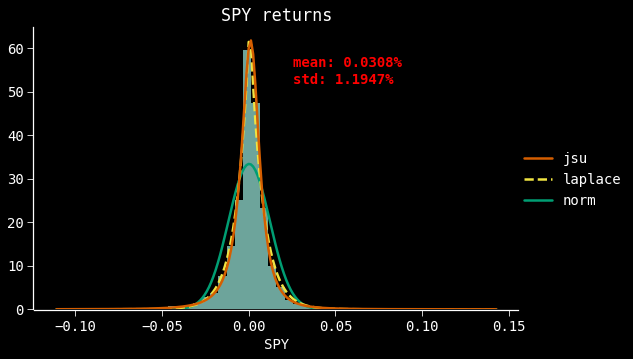

In [14]:
plot_dist(df, ex)

- `briefly introduce the chosen method for model evaluation and touch on the logic for why (AIC, BIC, DWAIC)`
- `start with sklearn demo using gaussian mixture with 1 component as example of fitting 1 normal distribution to the dataset, plot the densities`
- `then move to 2, 3, 4, N components`
- `discuss that in the limit, every data point can be fit with Gaussian with what effects on the mean and variance? but will certainly be overfit`
- `after provide bonus or appendix that describes the underlying expectation maximization algorithm`

In [5]:
help(mix.GaussianMixture)

Help on class GaussianMixture in module sklearn.mixture.gaussian_mixture:

class GaussianMixture(sklearn.mixture.base.BaseMixture)
 |  Gaussian Mixture.
 |  
 |  Representation of a Gaussian mixture model probability distribution.
 |  This class allows to estimate the parameters of a Gaussian mixture
 |  distribution.
 |  
 |  Read more in the :ref:`User Guide <gmm>`.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  n_components : int, defaults to 1.
 |      The number of mixture components.
 |  
 |  covariance_type : {'full', 'tied', 'diag', 'spherical'},
 |          defaults to 'full'.
 |      String describing the type of covariance parameters to use.
 |      Must be one of::
 |  
 |          'full' (each component has its own general covariance matrix),
 |          'tied' (all components share the same general covariance matrix),
 |          'diag' (each component has its own diagonal covariance matrix),
 |          'spherical' (each component has its own sing

preprocess data

In [96]:
symbol = 'SPY'
s = df[symbol].copy()
X = s.reshape(-1,1)
s[:5]

Date
2005-01-03   -0.0047
2005-01-04   -0.0123
2005-01-05   -0.0069
2005-01-06    0.0051
2005-01-07   -0.0014
Name: SPY, dtype: float64

In [34]:
def make_gmm(n_components, max_iter, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, max_iter=max_iter,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

In [35]:
RANDOM_STATE = 777
k = 1
max_iter = 150 

gmm1 = make_gmm(k, max_iter)

In [36]:
gmm1.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [37]:
preds = gmm1.predict(X)

In [38]:
gmm1.means_, gmm1.covariances_

(array([[ 0.00030842]]), array([[[ 0.00014369]]]))

In [39]:
gmm1.bic(X)

-19292.246386802919

In [40]:
gmm2 = make_gmm(2, max_iter)
gmm2.fit(X)
gmm2.predict(X)
gmm2.means_, gmm2.covariances_, gmm2.bic(X)

(array([[-0.00263246],
        [ 0.00089767]]), array([[[  6.14422437e-04]],
 
        [[  4.72895216e-05]]]), -20438.972104693737)

In [41]:
gmm10 = make_gmm(10, max_iter)
gmm10.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [42]:
gmm10.means_, gmm10.covariances_, gmm10.bic(X)

(array([[ 0.00174487],
        [-0.02127485],
        [ 0.03218533],
        [-0.07698017],
        [-0.00239338],
        [ 0.01576889],
        [ 0.12303798],
        [-0.04190984],
        [ 0.00767909],
        [-0.01028666]]), array([[[  8.60805439e-06]],
 
        [[  3.37830536e-05]],
 
        [[  1.60395923e-04]],
 
        [[  2.36984238e-04]],
 
        [[  1.01469164e-05]],
 
        [[  2.24100205e-05]],
 
        [[  1.58469532e-04]],
 
        [[  6.75960043e-05]],
 
        [[  1.22318000e-05]],
 
        [[  1.49550740e-05]]]), -20410.842140456374)

In [67]:
%%time 

ks = np.arange(1,20,2)
aics = []
bics = []

for k in ks:
    tmp_gmm = make_gmm(k, max_iter).fit(s)
    aics.append((k, tmp_gmm.aic(s)))
    bics.append((k, tmp_gmm.bic(s)))

CPU times: user 984 ms, sys: 2.79 s, total: 3.78 s
Wall time: 728 ms


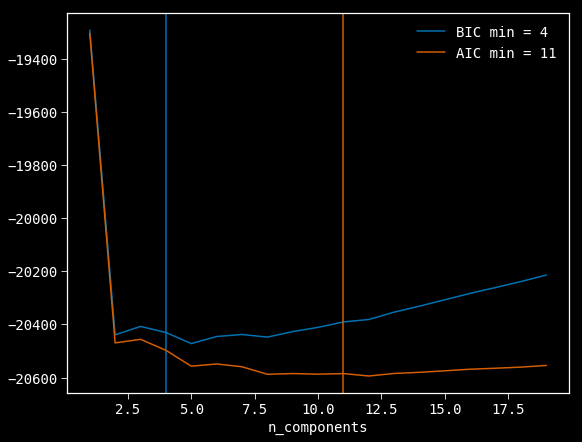

In [89]:
n_components = np.arange(1, 20)
models = [make_gmm(n, max_iter).fit(s)
          for n in n_components]

bic = [m.bic(s) for m in models]
aic = [m.aic(s) for m in models]

plt.plot(n_components, bic, color=blue, label=f'BIC min = {np.argmin(bic)}')
plt.axvline(np.argmin(bic), color=blue)

plt.plot(n_components, aic, color=red, label=f'AIC min = {np.argmin(aic)}')
plt.axvline(np.argmin(aic), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');

In [125]:
s.index.values

array(['2005-01-03T00:00:00.000000000', '2005-01-04T00:00:00.000000000',
       '2005-01-05T00:00:00.000000000', ...,
       '2017-09-27T00:00:00.000000000', '2017-09-28T00:00:00.000000000',
       '2017-09-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [131]:
from matplotlib.dates import YearLocator, MonthLocator

dt_min = s.index.min()
dt_max = s.index.max()

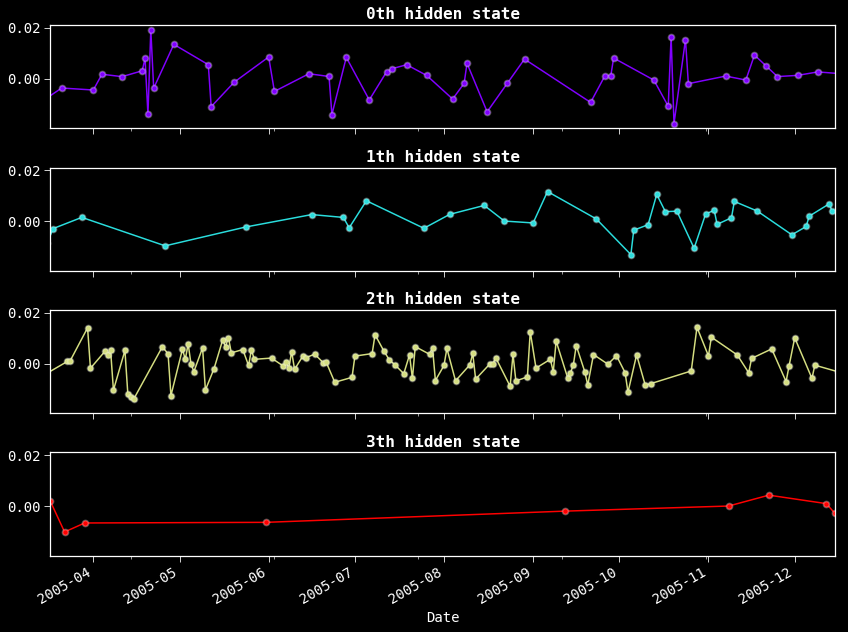

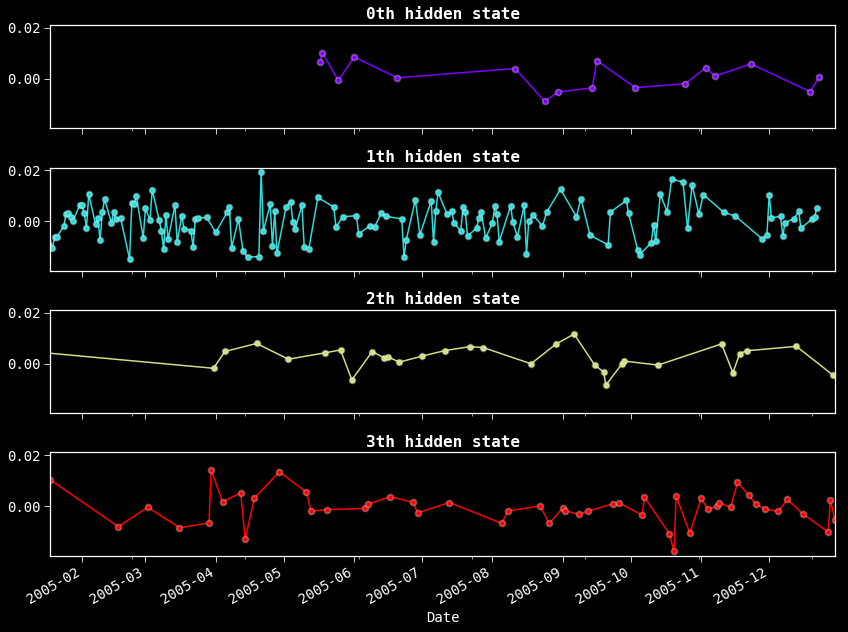

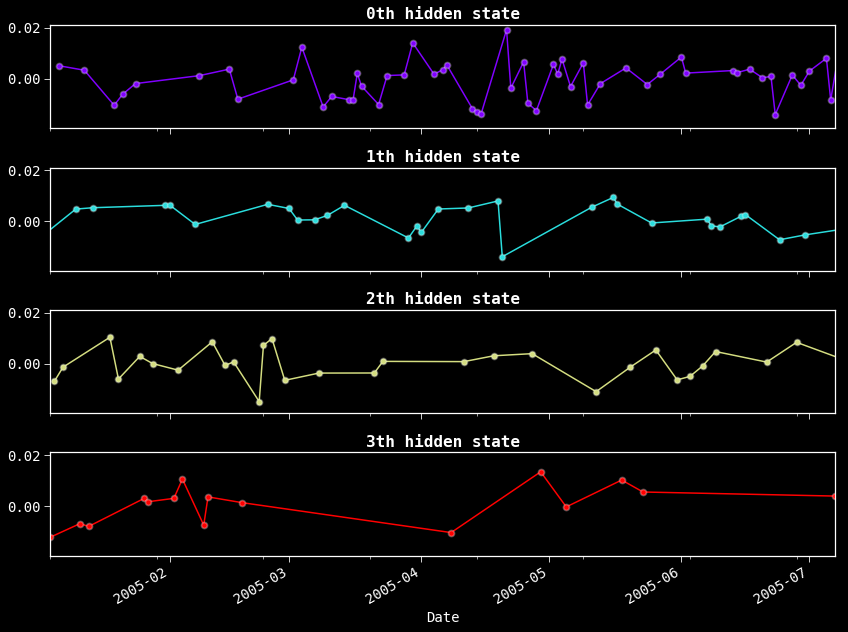

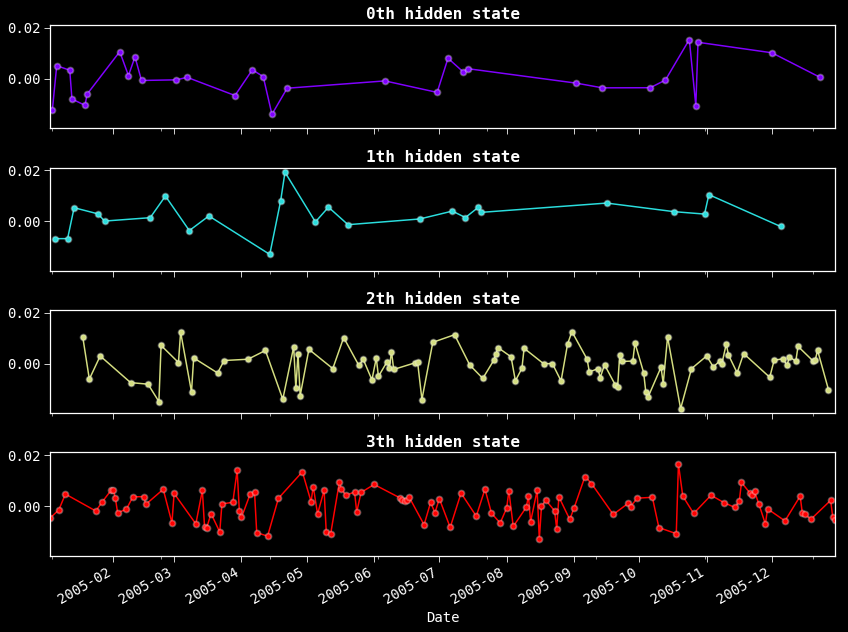

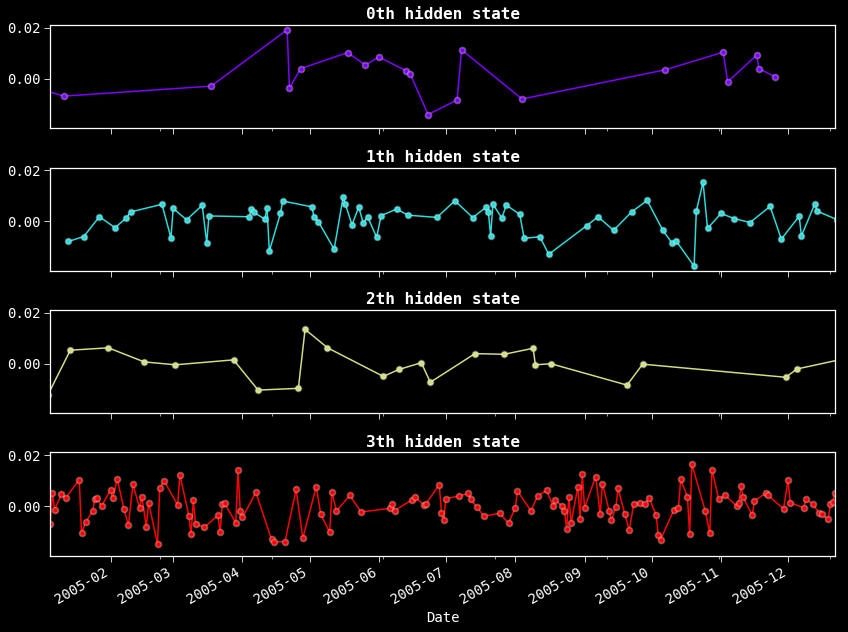

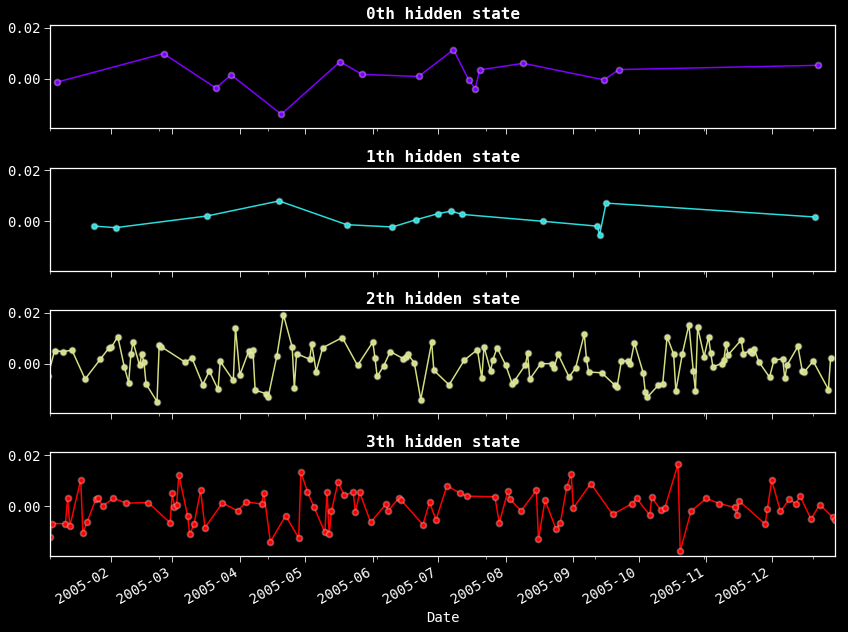

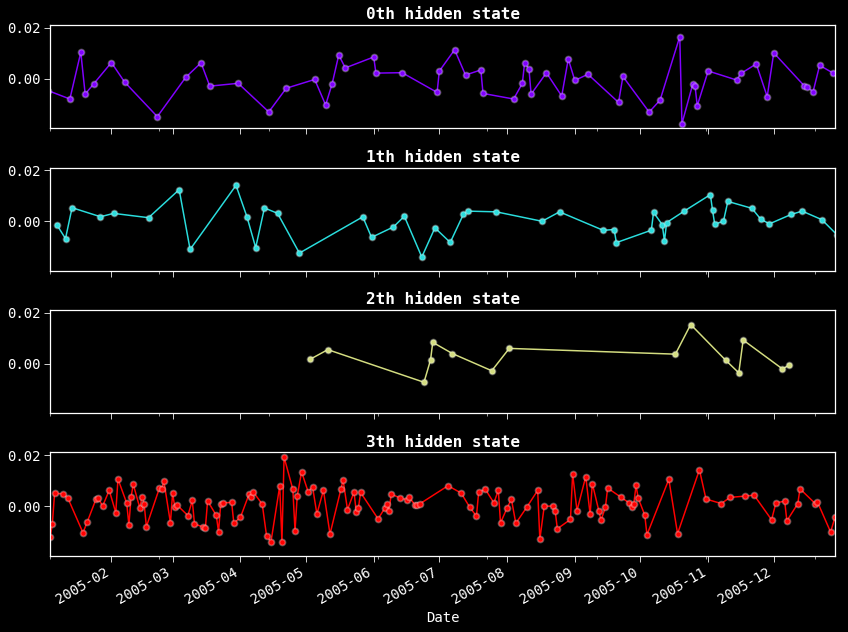

In [172]:
from sklearn.model_selection import TimeSeriesSplit

#xx = df[ex].copy() # pd series representing example data

_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5] # historical lookbacks
#_splits = np.arange(2, 12, 2)
_n_split=5 # try with different values

gs = gridspec.GridSpec(_n_split, len(_max_train_sizes), wspace=0.0)

fig = plt.figure(figsize=(20,25))

preds = []
pred_means = []
pred_covs = []

rows = []
#for j, max_size in enumerate(_max_train_sizes):
tscv = TimeSeriesSplit(n_splits=7, max_train_size=_base)

for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = X[train] # temporary train data
    tmp_test = X[test] # temporary test data

    gmm = make_gmm(4, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    fig, axs = plt.subplots(gmm.n_components, sharex=True, sharey=True, figsize=(12,9))
    colors = plt.cm.rainbow(np.linspace(0, 1, gmm.n_components))

    for i, (ax, color) in enumerate(zip(axs, colors)):
        
        hs = pd.Series(hidden_states.copy())
        mask = hs[hs==i] # index locs of each state
        
        marker_edge_color = mpl.colors.colorConverter.to_rgba('white', alpha=.3)
        s[mask.index].plot(ax=ax, c=color, 
                           marker='o', markersize=6, 
                           markeredgecolor=marker_edge_color,
                           markeredgewidth=1.75)

        ax.set_title(f"{i}th hidden state", fontsize=16, fontweight='demi')

    plt.tight_layout()    
    #break
    # get date ranges for datasets
    #min_train_dt, max_train_dt = tmp_train.index.min(), tmp_train.index.max()
    #min_test_dt, max_test_dt = tmp_test.index.min(), tmp_test.index.max()

((534,), (3209,))

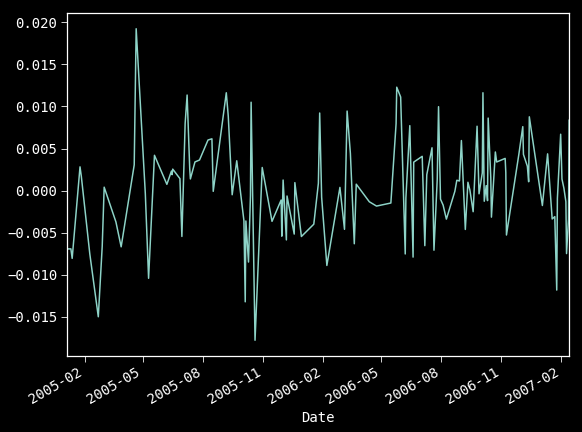

In [149]:
hs = pd.Series(hidden_states.copy())
s[hs[hs==0].index].plot()

        Date  states     SPY  mkt_cret
0 2005-01-03       1 -0.0047   -0.0047
1 2005-01-04       3 -0.0123   -0.0170
2 2005-01-05       0 -0.0069   -0.0239
3 2005-01-06       1  0.0051   -0.0189
4 2005-01-07       3 -0.0014   -0.0203


(array([ 731978.,  732067.,  732159.,  732251.,  732343.,  732432.,
         732524.,  732616.,  732708.]), <a list of 9 Text xticklabel objects>)

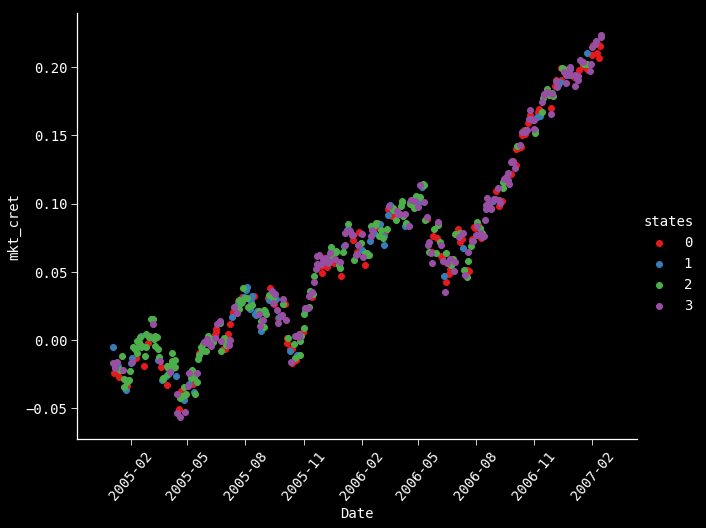

In [121]:
tmp_s = s[:hidden_states.shape[0]]
states = (pd.DataFrame(hidden_states, columns=['states'], index=tmp_s.index)
          .join(s, how='inner')
          .assign(mkt_cret=tmp_s.cumsum())
          .reset_index(drop=False))

print(states.head())

order = np.arange(gmm.n_components)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette="Set1", aspect=1.31, size=7)
fg.map(plt.scatter, 'Date', 'mkt_cret').add_legend()
plt.xticks(rotation=50);

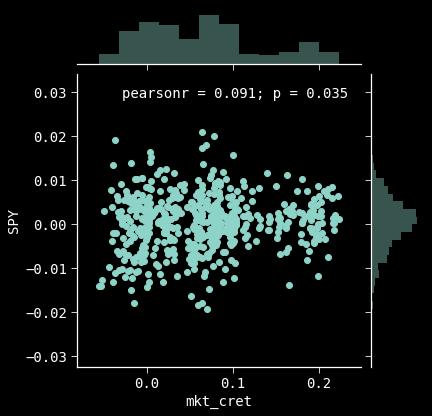

In [189]:
sns.jointplot(data=states, x='states', y='SPY')

In [ ]:
sns.

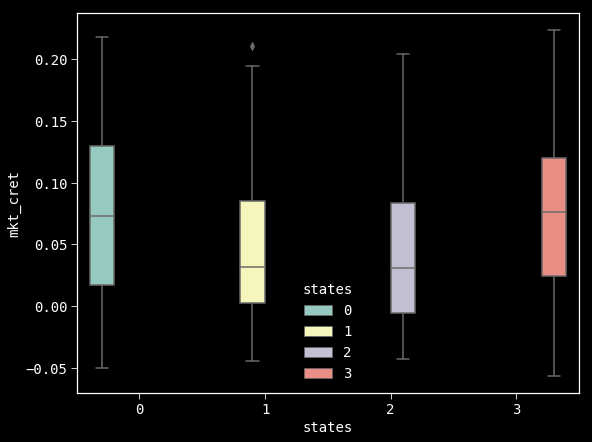

In [176]:
sns.boxplot(x="states", y="mkt_cret", hue="states", data=states)

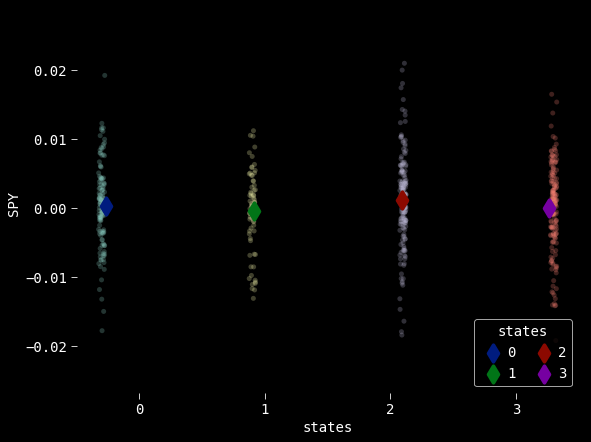

In [190]:
sym = 'SPY'
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="states", y=sym, hue="states", data=states,
              dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="states", y=sym, hue="states", data=states,
              dodge=.532, join=False, palette="dark",
              markers="d", markersize=6, scale=1.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title="states",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=2, frameon=True)

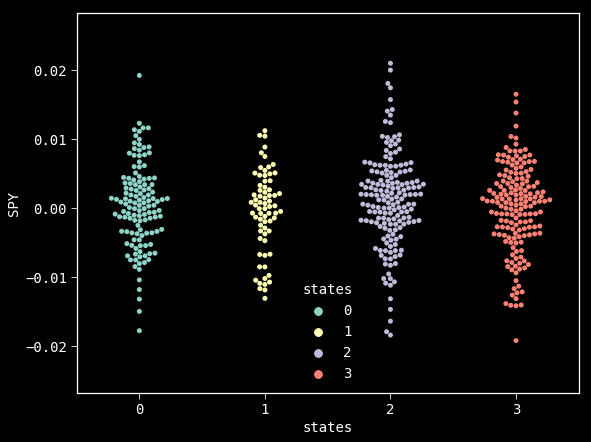

In [186]:
# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="states", y="SPY", hue="states", data=states)

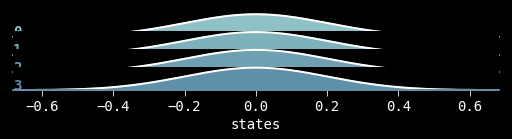

In [187]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(states, row="states", hue="states", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "SPY", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "SPY", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "states")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)